<a href="https://colab.research.google.com/github/JNicastri1/projetoML/blob/main/projeto_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho de Machine Learning
Equipe: Abraão Guimarães, João Nicastri, Raphael Muniz, Kaio Zaniboni, Felipe Brum

# Base de Dados: Fraud Detection Transactions Dataset
A Fraud Detection Transactions Dataset é uma base sintética de alta qualidade voltada para experimentos de detecção de fraudes em transações financeiras. Ela foi disponibilizada no Kaggle para apoiar a construção e comparação de modelos de machine learning, em cenários com classes altamente desbalanceadas.

Link: https://www.kaggle.com/datasets/samayashar/fraud-detection-transactions-dataset/data

# Atributos da Base


* Transaction_ID:	Identificador único de cada transação
* User_ID:	Identificador único do usuário responsável pela transação
* Transaction_Amount:	Valor monetário da transação
* Transaction_Type:	Tipo de transação (por exemplo, PAYMENT, TRANSFER, CASH_OUT, etc.)
* Timestamp:	Carimbo de data e hora em que a transação ocorreu
* Account_Balance:	Saldo da conta do usuário no momento da transação
* Device_Type:	Tipo de dispositivo utilizado para executar a transação (desktop, mobile, tablet etc.)
* Location:	Localização geográfica ou região onde a transação foi iniciada
* Merchant_Category:	Categoria do comerciante ou estabelecimento onde a transação foi processada
* IP_Address_Flag:	Indicador binário (0/1) sinalizando se o IP de origem é suspeito
* Previous_Fraudulent_Activity:	Indicador (0/1) de histórico prévio de atividades fraudulentas pelo mesmo usuário
* Daily_Transaction_Count:	Quantidade de transações já realizadas pelo usuário no mesmo dia
* Avg_Transaction_Amount_7d:	Valor médio das transações do usuário nos últimos 7 dias
* Failed_Transaction_Count_7d:	Número de tentativas de transação sem sucesso nos últimos 7 dias
* Card_Type:	Tipo de cartão utilizado (crédito, débito, pré-pago etc.)
* Card_Age:	Idade do cartão em uso, geralmente medida em meses
* Transaction_Distance:	Distância geográfica entre o local habitual do usuário e o local da transação
* Authentication_Method:	Método de autenticação empregado (senha, biometria, OTP etc.)
* Risk_Score:	Pontuação de risco atribuída à transação por sistemas de prevenção a fraudes
* Is_Weekend:	Indicador (0/1) informando se a transação ocorreu em fim de semana
* Fraud_Label: 	Rótulo alvo do modelo (1 indica fraude comprovada, 0 indica transação legítima)

#Imports

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samayashar/fraud-detection-transactions-dataset")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\mucos\.cache\kagglehub\datasets\samayashar\fraud-detection-transactions-dataset\versions\1


In [ ]:
#separando os imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE



#retirando os warnings
import warnings
warnings.filterwarnings('ignore')

# colocando um estilo para o seaborn
sns.set_style("whitegrid")

# Qual o Problema?


* Conseguir identificar transações fraudulentas de acordo com as características das movimentações.
** Identificar qual modelo apresentou melhores resultados de acordo com a métrica escolhida.
** Mostrar mais são as características mais relevantes do modelo com melhores resultados.

# Quais são os desafios de trabalhar com fraudes?




* **Desequilíbrio de Classes:** Em cenários de fraude, a proporção de transações legítimas costuma superar por muito as fraudulentas, o que leva os modelos supervisionados a favorecerem sempre a classe majoritária.

* **Mudança nos Padrões de Fraude:** Fraudadores adaptam constantemente suas táticas para driblar sistemas de segurança. Essa dinâmica obriga a atualização frequente de modelos.

* **Falsos Positivos e Falsos Negativos:** Excesso de falsos positivos eleva custos com investigações manuais e degrada a experiência do cliente. Por outro lado, falsos negativos reduz a eficácia do sistema, aumentando o prejuízo da institução financeira.

# Quais as Métricas para Avaliar o Modelo?







* **F1-Score:**  Combina "Precisão" e "Recall" num único valor, calculando a média harmônica entre eles. Excelente para cenários desbalanceados, pois só cresce se ambos estiverem altos.  <br>Precisão:  mostra a proporção de alertas classificados como fraudes que realmente são fraudulentos. Alarme falso faz com que analistas e sistemas passem a ignorar sinais de alerta reais devido ao alto volume de falsos positivos. <br>Recall:  Mede porcentagem de fraudes corretamente detectadas pelo modelo. Fraude não identificada pode gerar prejuízo financeiro e de imagem para Institução Financeira.


* **AUC-ROC:** É a metrica que calcula a área sob e curva ROC, refletindo o equilíbrio entre detectar fraudes e minimizar alarmes falsos. A curva ROC exibe a taxa de verdadeiros positivos contra a taxa de falsos positivos.

* **Matriz de Confusão:** A matriz de confusão é fundamental para avaliar modelos de classificação binária porque ela oferece uma visão detalhada e do desempenho do modelo, exibindo os TP, TN, FP e FN.

In [ ]:
data = pd.read_csv(path+"/synthetic_fraud_dataset.csv")

data.head()


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


# Análise Exploratória da Base de Dados


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

In [ ]:
# Converter a coluna TimeStamp de string para data
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

# Removendo as colunas de ID do dataframe
#data.drop(columns=['Transaction_ID', 'User_ID'], inplace=True)
# retirado o DROP para poder mantermos a identificação dos usuários e transações

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Transaction_ID                50000 non-null  object        
 1   User_ID                       50000 non-null  object        
 2   Transaction_Amount            50000 non-null  float64       
 3   Transaction_Type              50000 non-null  object        
 4   Timestamp                     50000 non-null  datetime64[ns]
 5   Account_Balance               50000 non-null  float64       
 6   Device_Type                   50000 non-null  object        
 7   Location                      50000 non-null  object        
 8   Merchant_Category             50000 non-null  object        
 9   IP_Address_Flag               50000 non-null  int64         
 10  Previous_Fraudulent_Activity  50000 non-null  int64         
 11  Daily_Transaction_Count     

In [ ]:
X_info = data.drop(columns=['Fraud_Label', 'Transaction_ID', 'User_ID'])
linhas, colunas = X_info.shape

print(f"Número de amostras: {linhas}")
print(f"Número de features: {colunas}")
print(f"Nomes das classes: {X_info.columns}")

Número de amostras: 50000
Número de features: 18
Nomes das classes: Index(['Transaction_Amount', 'Transaction_Type', 'Timestamp',
       'Account_Balance', 'Device_Type', 'Location', 'Merchant_Category',
       'IP_Address_Flag', 'Previous_Fraudulent_Activity',
       'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
       'Failed_Transaction_Count_7d', 'Card_Type', 'Card_Age',
       'Transaction_Distance', 'Authentication_Method', 'Risk_Score',
       'Is_Weekend'],
      dtype='object')


In [ ]:
# separando as colunas numéricas das categóricas para exibição dos histogramas e countplot
numeric_cols = data.select_dtypes(include=["int64", "float64", "datetime64[ns]"]).columns
categorical_cols = data.select_dtypes(include=["object"]).columns.drop(['Transaction_ID', 'User_ID'])

print ("Colunas numéricas:", numeric_cols)
print ("Colunas categóricas:", categorical_cols)


Colunas numéricas: Index(['Transaction_Amount', 'Timestamp', 'Account_Balance', 'IP_Address_Flag',
       'Previous_Fraudulent_Activity', 'Daily_Transaction_Count',
       'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age',
       'Transaction_Distance', 'Risk_Score', 'Is_Weekend', 'Fraud_Label'],
      dtype='object')
Colunas categóricas: Index(['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category',
       'Card_Type', 'Authentication_Method'],
      dtype='object')


## Histogramas das *Features* Numéricas

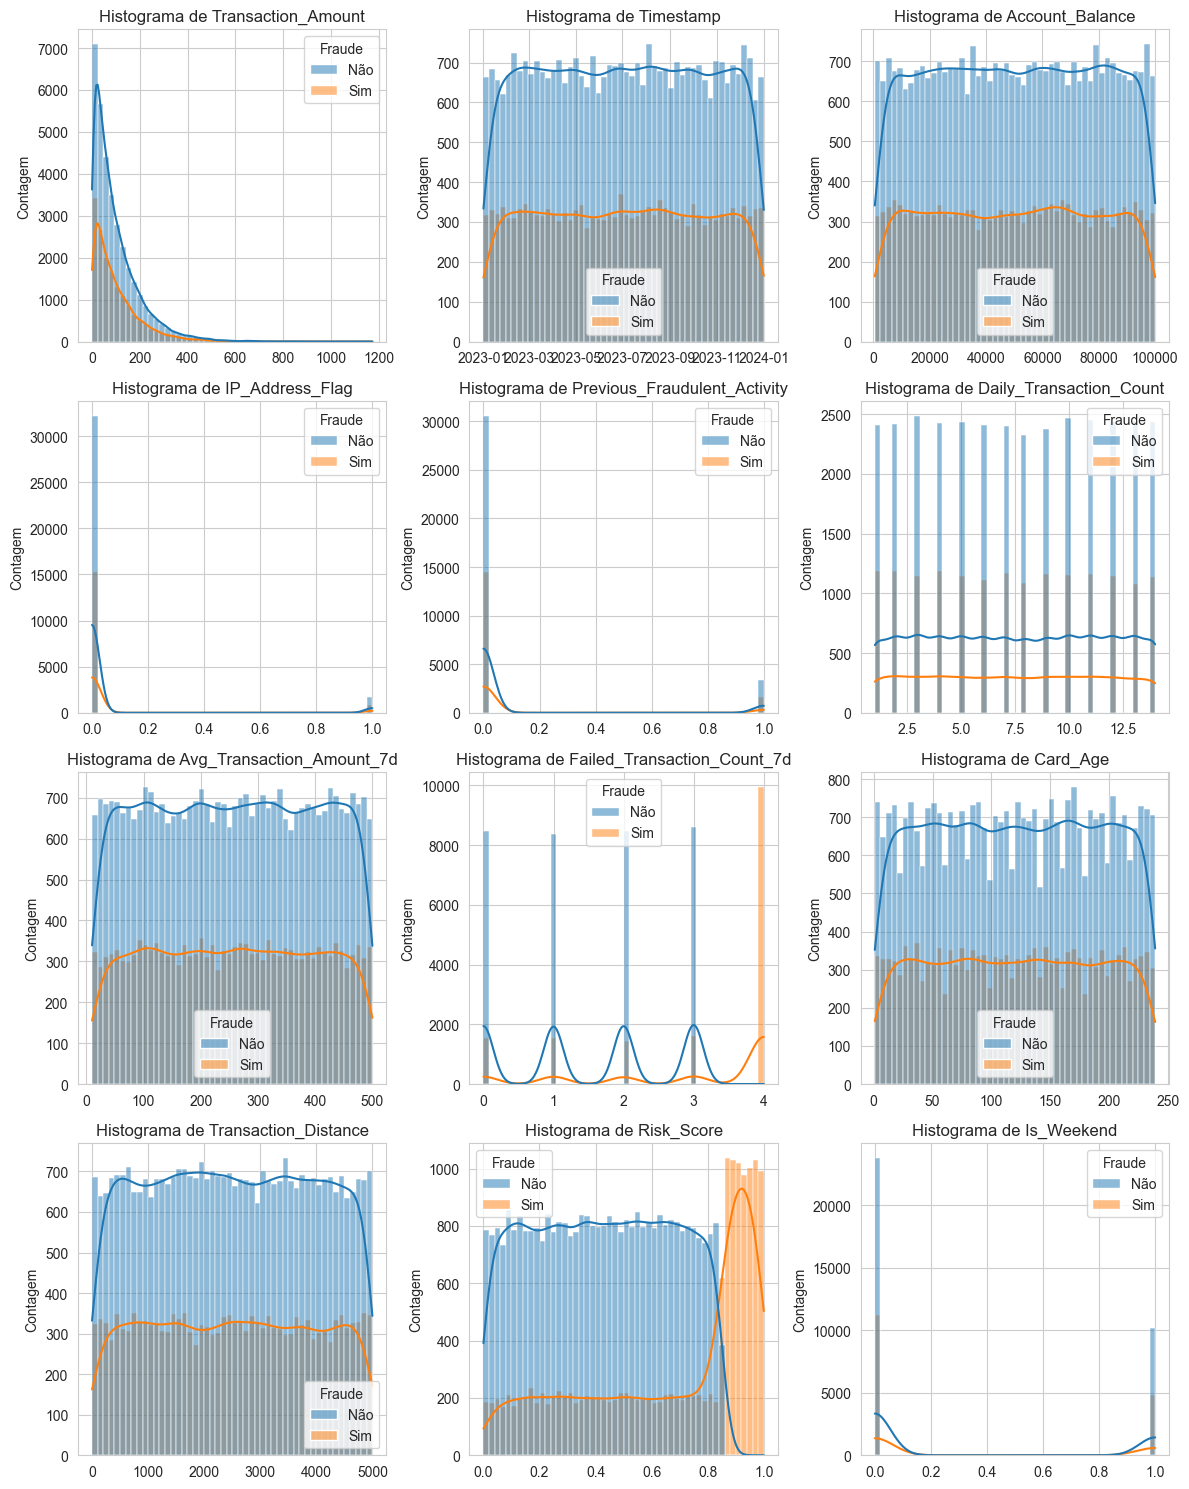

In [ ]:
# Criando a matriz de histogramas
fig, axes = plt.subplots(4, 3, figsize=(12, 15))

# Achatando a matriz de eixos
axes = axes.flatten()

# Removendo a coluna Fraud_Label do histograma, pois estamos usando hue
numeric_cols2 = [col for col in numeric_cols if col != 'Fraud_Label']

# Mapeando 0:Nao e 1:Sim e colocando em uma coluna de nome "Fraude"
data['Fraude'] = data['Fraud_Label'].map({0: 'Não', 1: 'Sim'})

# Percorrendo as colunas numéricas
for i, col in enumerate(numeric_cols2):
    sns.histplot(data=data, x=col, bins=50, kde=True, hue='Fraude', ax=axes[i])
    axes[i].set_title(f"Histograma de {col}", fontsize=12)
    axes[i].set_ylabel("Contagem", fontsize=10)
    axes[i].set_xlabel('')

# Removendo os eixos não utilizados
for i in range(len(numeric_cols2), len(axes)):
    fig.delaxes(axes[i])

# Ajustando o layout
plt.tight_layout()

# Plotando o gráfico
plt.show()

* A área com Risk_Score acima de 0.9 é onde a maioria das transações fraudulentas se encontra. (resultado já esperado)
* O Risk_Score baixo (menor que 0.9) é um forte indicador de transação legítima nesta base de dados, enquanto um escore alto (maior que 0.9) é um indicador de transação fraudulenta.

* Alto Valor de *Failed_Transaction_Count_7d*: Uma contagem de 4 transações falhadas nos últimos 7 dias é um forte indicador de que a transação é fraudulenta.

* Baixo Valor de *Failed_Transaction_Count_7d* Uma contagem de 0, 1, 2 ou 3 transações falhadas nos últimos 7 dias é um forte indicador de que a transação é legítima.

## BoxPlot das *Features* Numéricas Não Binárias

* O Boxplot é uma ferramenta estatística projetada para visualizar a distribuição de variáveis numéricas contínuas ou discretas com muitos valores.
* A "distribuição" de dados binários não tem sentido em termos de quartis ou mediana da forma como o boxplot os apresenta.


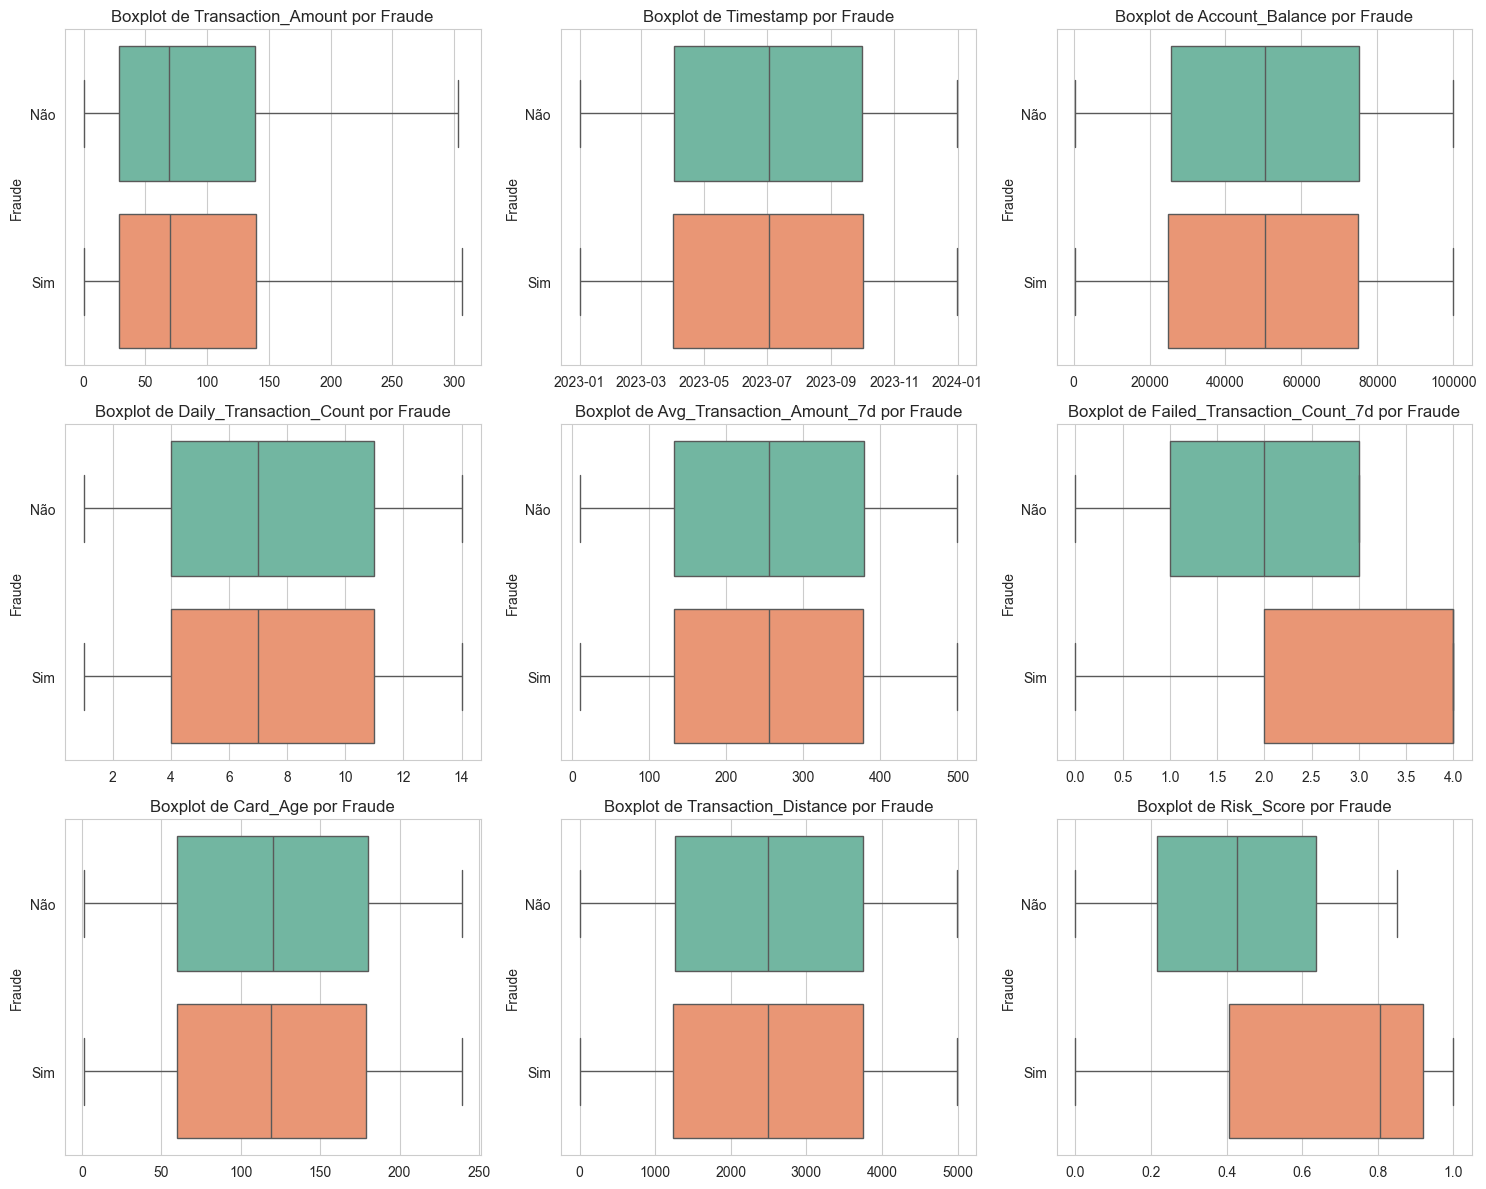

In [ ]:

# Removendo as variaveis binárias da base
non_binary_cols = [
    col for col in numeric_cols
    if len(data[col].unique()) > 2
]

# Criando a figura e os subplots (matriz 3x3)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Iterando sobre as colunas
for i, col in enumerate(non_binary_cols):
    sns.boxplot( data=data, x=col, y='Fraude', palette="Set2", showfliers=False, ax=axes[i])

    # Definindo os títulos e rótulos
    axes[i].set_title(f"Boxplot de {col} por Fraude", fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel("Fraude", fontsize=10)

# Removendo os graficos vazios
for i in range(len(non_binary_cols), len(axes)):
    fig.delaxes(axes[i])

#Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()


* BoxPlot reforçando a ideia:
** Registros com Risk_Score alto são indicadores de transações fraudulentas.
<br>
** Alto Valor de Failed_Transaction_Count_7d é um forte indicador de que a transação é fraudulenta.


## Gráfico de Barras para a contagem das *Features* Categóricas


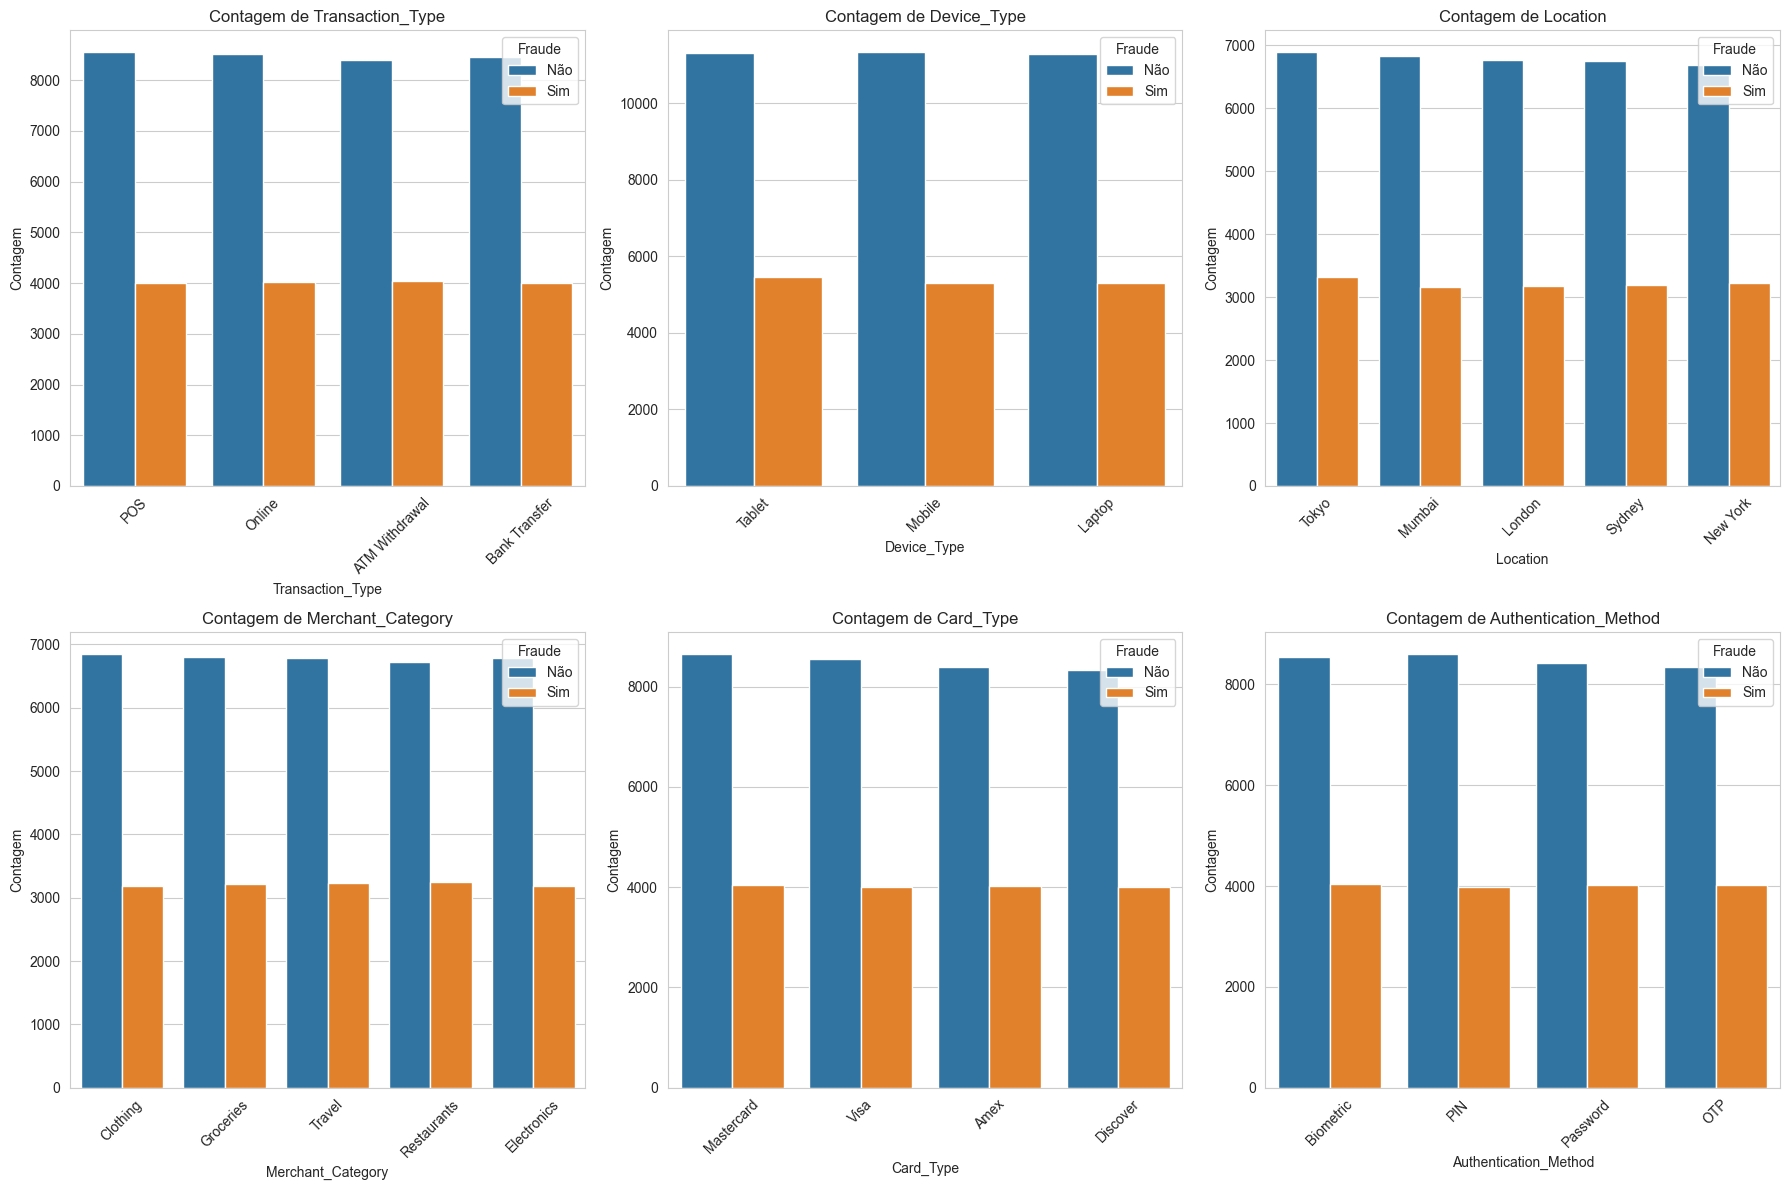

In [ ]:

# Cria a figura e os subplots.
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes = axes.flatten()

# Percorrendo as categóricas
for i, col in enumerate(categorical_cols):
    if i < 12:
        sns.countplot(data=data, x=col, hue='Fraude', order=data[col].value_counts().index, ax=axes[i])

        # Ajustando os títulos e rótulos
        axes[i].set_title(f"Contagem de {col}", fontsize=12)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel("Contagem", fontsize=10)

        # Rotacionando o eixo X
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

* Em uma primeira análise visual, de forma geral as variáveis categóricas não ajudam a diferenciar transações fraudulentas das não fraudulentas. (Pelo menos na visualização das variáveis de forma independente)

## Matriz de Correlação com Mapa de Calor

### Correlação de Pearson: Mede a relação linear entre duas variáveis.

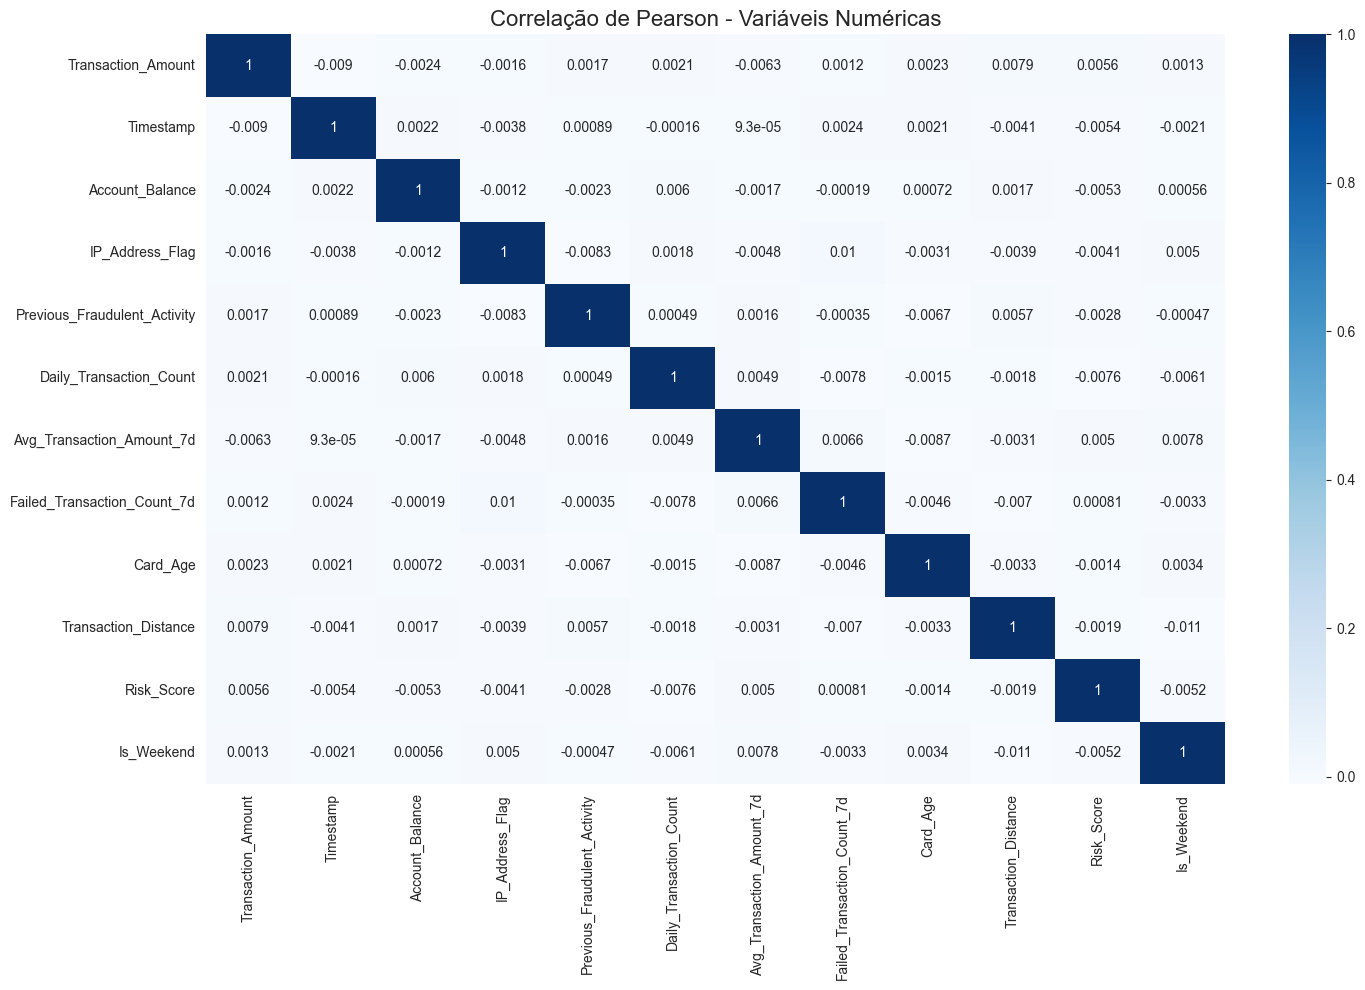

In [ ]:
data_numeric = data[numeric_cols].drop(columns=['Fraud_Label'])

plt.figure(figsize=(15, 10))

sns.heatmap(data_numeric.corr(), annot=True, cmap='Blues')

plt.title("Correlação de Pearson - Variáveis Numéricas", fontsize=16)
plt.tight_layout()
plt.show()

### Correlação de Spearman:

Mede a relação de monotonicidade, que é uma relação geral entre duas variáveis, sem se importar com a forma exata dessa relação.

Funciona com os rankings dos valores, em vez dos próprios valores, tornando-o menos sensível a outliers e a relações não lineares.

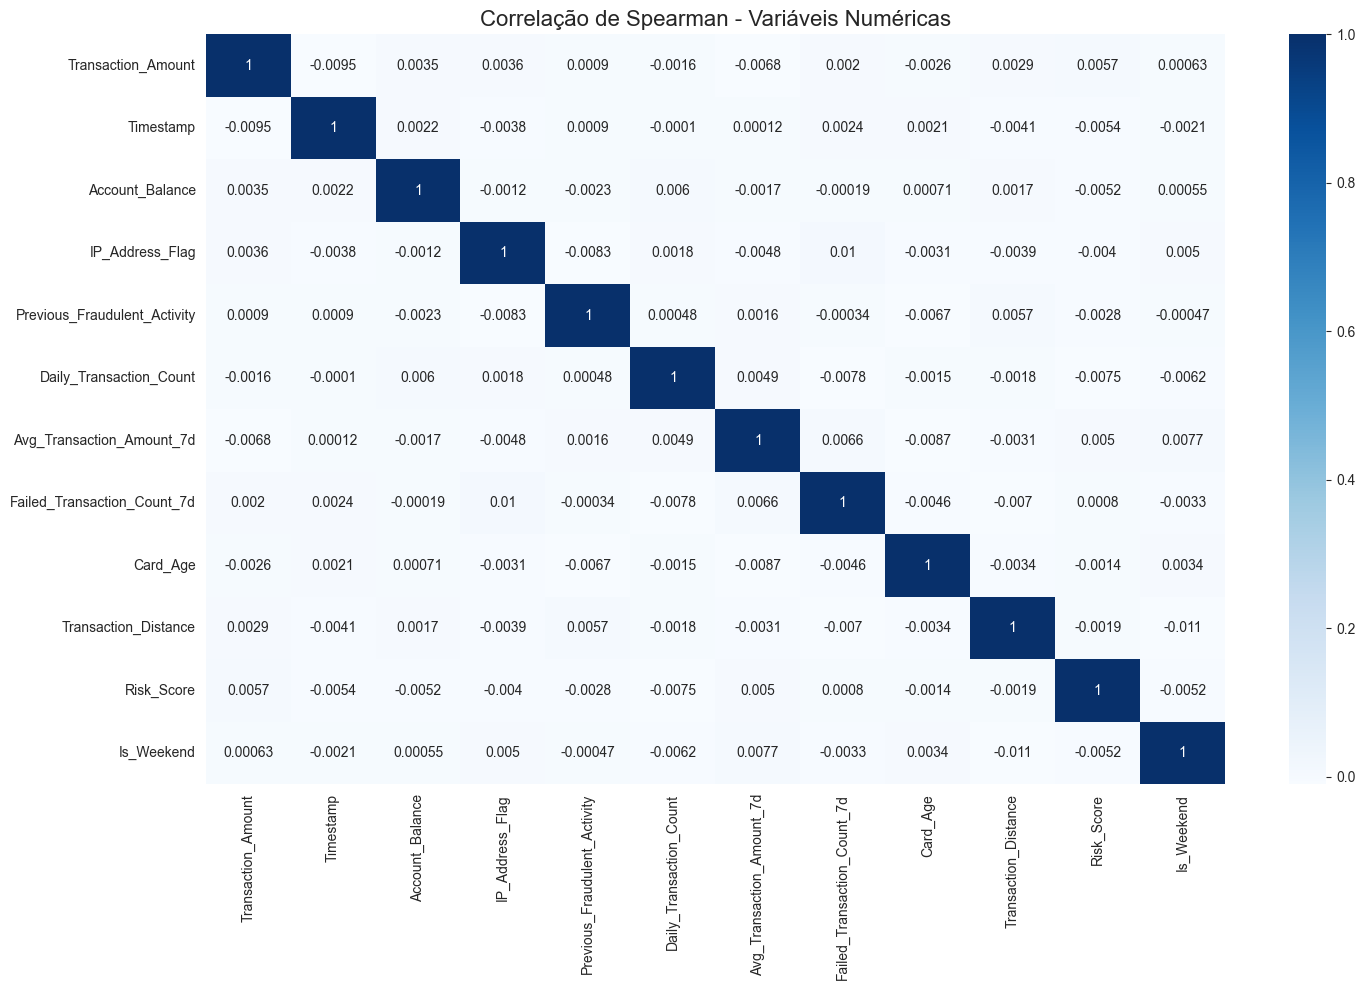

In [ ]:
plt.figure(figsize=(15, 10))

sns.heatmap(data_numeric.corr(method="spearman"), annot=True, cmap='Blues')

plt.title("Correlação de Spearman - Variáveis Numéricas", fontsize=16)
plt.tight_layout()
plt.show()

#Tratamento e Limpeza dos Dados

In [ ]:
#Separando o horario, o dia da semana e o mês do timestamp
data['Hour'] = data['Timestamp'].dt.hour
data['Weekday'] = data['Timestamp'].dt.weekday
data['Month'] = data['Timestamp'].dt.month

data.drop('Timestamp', axis=1, inplace=True)

data.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,...,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label,Fraude,Hour,Weekday,Month
0,TXN_33553,USER_1834,39.79,POS,93213.17,Laptop,Sydney,Travel,0,0,...,65,883.17,Biometric,0.8494,0,0,Não,19,0,8
1,TXN_9427,USER_7875,1.19,Bank Transfer,75725.25,Mobile,New York,Clothing,0,0,...,186,2203.36,Password,0.0959,0,1,Sim,4,2,6
2,TXN_199,USER_2734,28.96,Online,1588.96,Tablet,Mumbai,Restaurants,0,0,...,226,1909.29,Biometric,0.8400,0,1,Sim,15,1,6
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,76807.20,Tablet,New York,Clothing,0,0,...,76,1311.86,OTP,0.7935,0,1,Sim,0,3,12
4,TXN_39489,USER_2014,31.28,POS,92354.66,Mobile,Mumbai,Electronics,0,1,...,140,966.98,Password,0.3819,1,1,Sim,23,5,11


É fundamental separar a coluna de timestamp em componentes como hora, dia da semana e mês. Essa técnica de "engenharia de features" captura os padrões periódicos. A separação permite que o modelo identifique e aprenda com a periodicidade dos eventos:<br>
**Hour:** O modelo pode aprender que a atividade fraudulenta é menor nas horas da tarde e maior nas madrugadas, por exemplo.<br>
**Weekday:** O modelo pode identificar que as fraudes são maiores em algum dia específico da semana.<br>
**Month:** O modelo pode aprender com a sazonalidade, como um aumento nas fraudes podem ocorrer em determinado período, como pagamento de salários no quinto dia útil.

In [ ]:
# após o tratamanto, separar novamente as colunas numéricas das categóricas
numeric_cols = data.select_dtypes(include=["int64", "float64", "datetime64[ns]", "int32"]).columns.drop('Fraud_Label')
categorical_cols = data.select_dtypes(include=["object"]).columns.drop(['Fraude', 'Transaction_ID', 'User_ID'])

print ("Colunas numéricas:", numeric_cols)
print ("Colunas categóricas:", categorical_cols)

Colunas numéricas: Index(['Transaction_Amount', 'Account_Balance', 'IP_Address_Flag',
       'Previous_Fraudulent_Activity', 'Daily_Transaction_Count',
       'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age',
       'Transaction_Distance', 'Risk_Score', 'Is_Weekend', 'Hour', 'Weekday',
       'Month'],
      dtype='object')
Colunas categóricas: Index(['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category',
       'Card_Type', 'Authentication_Method'],
      dtype='object')


In [ ]:
#separando em X e y

# Retirando do X os IDs, o target(Fraude e Fraud_Label)
X = data.drop(columns=['Fraud_Label', 'Fraude', 'Transaction_ID', 'User_ID'])
y = data['Fraud_Label']


# Retirando também o Risk_Score, pois acreditamos que essa coluna deva ser usado em problemas de Regressão nessa Base.
# Rodando com o risck_score o XGBoost apresentou 100% na F1-score. (muito raro modelo com 100% de acerto)
X = X.drop(columns=['Risk_Score'])
numeric_cols = numeric_cols.drop('Risk_Score')

print(X.columns)


Index(['Transaction_Amount', 'Transaction_Type', 'Account_Balance',
       'Device_Type', 'Location', 'Merchant_Category', 'IP_Address_Flag',
       'Previous_Fraudulent_Activity', 'Daily_Transaction_Count',
       'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Type',
       'Card_Age', 'Transaction_Distance', 'Authentication_Method',
       'Is_Weekend', 'Hour', 'Weekday', 'Month'],
      dtype='object')


## **Aplicar o MinMaxScaler nas variáveis numéricas:**


MinMaxScaler = Transforma as features para que fique em um intervalo é entre 0 e 1.<br>
* Benefícios do MinMaxScaler: <br>
** Evita que uma variável domine as outras.
** Beneficia modelos que calculam distâncias. (ex:KNN)
** Melhora a convergência de algoritmos que usam descida de gradiente (ex: Regressão Logística)
<br>
OBS: O XGBoost é baseado em árvore de decisão, por isso não é beneficiado pelo MinMaxScaler.
<br>
* Desafios do MinMaxScaler: <br>
** Muito sensível a outliers. A fórmula do MinMax Scaling depende diretamente dos valores mínimo e máximo da sua variável. Se houver um ou mais outliers, eles podem distorcer completamente a escala.
* Alternativas ao MinMaxScaler: <br>
** Standard Scaler: Modelo que usa média e desvio padrão na mudança de escala, tornando-o menos sensível a outliers, porém parte do pressuposto que as features possuam o comportamento de uma distribuição normal.
** RobustScaler: Técnica de pré-processamento de dados projetada para lidar com outliers de forma mais eficaz do que outros métodos de normalização.




## **Aplicar o OneHotEncoding nas variáveis categóricas:**
OneHotEncoding = Cria novas colunas para cada categoria única presente na variável original. As novas colunas são binárias, ou seja, só podem ter os valores 0 ou 1. <br>


Exemplo:

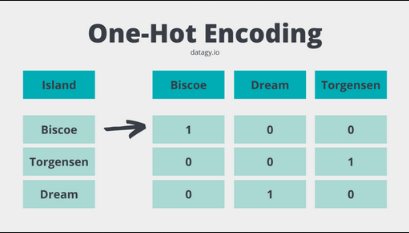


* Benefícios do OneHotEncoding: <br>
** Permite o uso de variáveis categóricas em modelos matemáticos (ex: KNN, Regressão Logística).
** Evita que os modelos utilizem ordem para as variáveis categóricas.
** Melhora o desempenho de modelos baseados em distância, pois todas as categóricas ficarão na mesma escala binária.
<br>
OBS: O XGBoost é baseado em árvore de decisão e dessa forma poderia trabalhar com dados categóricos.
<br>
* Desafios do OneHotEncoding: <br>
** Aumento da Dimensionalidade: O One-Hot Encoding pode agravar o problema de modelos com muitas dimensões, especialmente quando a variável categórica que você está codificando tem um grande número de categorias únicas. Isso gera aumento da complexidade do modelo, riscos de overfitting, matrizes esparsas.
<br>
* Alternativas ao OneHotEncoding: <br>
** Codificação por Frequência (Frequency Encoding): Substitui cada categoria pela sua frequência de ocorrência.
** Codificação por Alvo (Target Encoding): Substitui cada categoria pela média do valor da variável alvo para aquela categoria.


In [ ]:
#separando o X_numerico e o X_categorico
X_num = X[numeric_cols]
X_cat = X[categorical_cols]

#aplicando o MinMaxScaler nas numéricas
scaler = MinMaxScaler()
X_num2 = scaler.fit_transform(X_num)

#aplicando o OneHotEncoder nas categóricas
# gerando uma matriz densa de saída (não esparsa)
# ignorando se novas classes forem encontradas pelo modelo
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat2 = encoder.fit_transform(X_cat)

#concatenando as listas
X_prepro = np.concatenate([X_num2, X_cat2], axis=1)
X_prepro_colums = X_num.columns.to_list() + encoder.get_feature_names_out(X_cat.columns).tolist()

#criando um dataframe final
X_prepro_df = pd.DataFrame(X_prepro, columns=X_prepro_colums)

X_prepro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Transaction_Amount               50000 non-null  float64
 1   Account_Balance                  50000 non-null  float64
 2   IP_Address_Flag                  50000 non-null  float64
 3   Previous_Fraudulent_Activity     50000 non-null  float64
 4   Daily_Transaction_Count          50000 non-null  float64
 5   Avg_Transaction_Amount_7d        50000 non-null  float64
 6   Failed_Transaction_Count_7d      50000 non-null  float64
 7   Card_Age                         50000 non-null  float64
 8   Transaction_Distance             50000 non-null  float64
 9   Is_Weekend                       50000 non-null  float64
 10  Hour                             50000 non-null  float64
 11  Weekday                          50000 non-null  float64
 12  Month             

# Tratamento das Classes Desbalanceadas.
* Fenômeno comum em datasets de fraude.


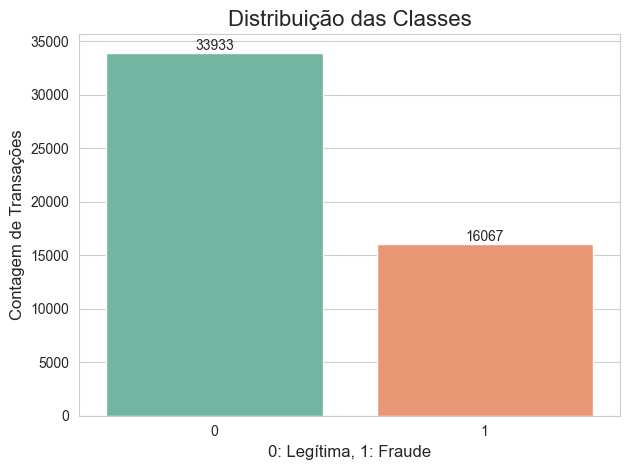

In [ ]:
# Criando gráfico de contagem das classes
ax = sns.countplot(x=y, palette='Set2')
'''
# apenas colocando a contagem dos registros em cima das barras
for p in ax.patches:
    height = int(p.get_height())
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 1,
        s=f'{height}',
        ha='center'
    )
'''

for container in ax.containers:
    ax.bar_label(container)

# colocando labels
plt.title("Distribuição das Classes", fontsize=16)
plt.xlabel("0: Legítima, 1: Fraude", fontsize=12)
plt.ylabel("Contagem de Transações", fontsize=12)

plt.tight_layout()
plt.show()

# Separação dos conjuntos de treinamento e teste e aplicar o SMOTE para balanceamento das classes de treino.


In [ ]:
# Separando os dados em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X_prepro_df, y, test_size=0.3, random_state=42, stratify=y)

## Aplicação do SMOTE

O SMOTE gera novos pontos de dados que sejam semelhantes, mas não idênticos, aos exemplos já existentes da classe minoritária.
* Benefícios do SMOTE: <br>
** O SMOTE resolve o problema do desbalanceamento de classes, criando novos dados sintéticos para a classe minoritária. Em vez de simplesmente copiar os dados existentes, o SMOTE seleciona exemplos da classe minoritária e, a partir deles, cria novos exemplos semelhantes, mas ligeiramente diferentes, usando interpolação. Isso equilibra o conjunto de dados e permite que o modelo aprenda melhor as características da classe minoritária.

* Desafios do SMOTE:<br>
** Ruído: Os novos dados sintéticos criados podem estar na região de outra classe, confundindo o modelo.
** Overlapping de Classes: O SMOTE não diferencia entre pontos de dados úteis e aqueles que já estão em regiões de sobreposição. Ele simplesmente cria novos pontos, o que pode piorar a sobreposição e dificultar para o modelo encontrar um limite de decisão claro.

* Alternativas ao SMOTE: <br>
** Random Oversampling: Consiste em copiar aleatoriamente exemplos da classe minoritária até que o conjunto de dados esteja balanceado.
** ADASYN: Variante do SMOTE, ele busca criar mais dados sintéticos para os exemplos da classe minoritária que são mais difíceis de classificar.

<br><br>
**IMPORTANTE:** O SMOTE é aplicado apenas no conjunto de treino, pois ele gera dados artificiais

In [ ]:
# Aplicando o SMOTE no treino (nunca no teste)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


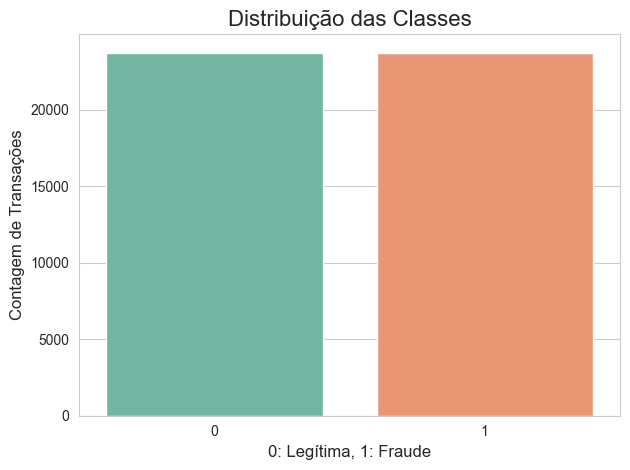

In [ ]:
#gerando o grafico da nova distribuição do Y de treino
ax = sns.countplot(x=y_train, palette='Set2')

# Adiciona título e rótulos
plt.title("Distribuição das Classes", fontsize=16)
plt.xlabel("0: Legítima, 1: Fraude", fontsize=12)
plt.ylabel("Contagem de Transações", fontsize=12)

plt.tight_layout()
plt.show()

#Implementação das Métricas de Avaliação:

In [ ]:
def imprimeMetricas(y_real, y_pred, y_proba=None):

    f1score = f1_score(y_real, y_pred)
    classif = classification_report(y_real, y_pred, digits=4)

    if y_proba is not None:
      rocauc = roc_auc_score(y_test, y_proba)
      print(f"AUC-ROC: {rocauc:.4f}\n")

    print(f"F1 Score: {f1score:.4f}\n")
    print(f"Classification Report:\n {classif}")

def imprimeMatrizConfusao(y_test, y_pred, norm=None):

    # Calculando a matriz de confusão
    cm = confusion_matrix(y_test, y_pred, normalize=norm)

    # Gerando a figura pro grafico
    fig, ax = plt.subplots(figsize=(6, 5))

    # Ajustando o título e o formato de exibição dos dados
    if norm is not None:
      cm = cm * 100
      fmt = ".2f"
      title = "Matriz de Confusão Normalizada (%)"
    else:
       title = "Matriz de Confusão"
       fmt = "d"

    # Montando o grafico da matriz
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem Fraude', 'Com Fraude'])
    disp.plot(ax=ax, values_format=fmt, cmap='Blues', colorbar=True)
    ax.set_title(title, fontsize=13, fontweight='bold')

    # Labels dos eixos
    ax.set_xlabel("Previsão", fontsize=12)
    ax.set_ylabel("Real", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Remove o grid ma matriz
    ax.grid(False)

    plt.tight_layout()
    plt.show()

# Modelo 1 - Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import os

SEED = 42
# validação cruzada estratificada, mantendo a proporção de fraude em cada fold, com splits estáveis e comparáveis entre rodadas (SEED).

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [ ]:
'''
Por que esses parâmetros no LogisticRegression

solver="saga": é o único solver do sklearn que suporta L1, L2 e elasticnet e lida bem com matrizes esparsas (que surgem após One-Hot Encoding). Também escala melhor para bases grandes.

max_iter=5000: dá folga para o otimizador convergir, especialmente quando usamos L1/elasticnet.

class_weight="balanced": reequilibra a perda ponderando a classe rara (fraude). Útil em datasets desbalanceados. Como já aplicamos o SMOTE no treino, não seria necessário. Podemos até testar SEM
n_jobs=-1: usa todos os núcleos disponíveis quando aplicável (no LR isso ajuda principalmente em cenários multiclasses OvR; em binário o ganho é pequeno, mas não atrapalha).
'''

rl = LogisticRegression(
    solver="saga",          # permite L1/L2/elasticnet
    max_iter=5000,
    class_weight="balanced",
    random_state=SEED,
    n_jobs=-1
)

param_dist_rl = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": np.logspace(-3, 2, 20),         # gera 20 valores, entre 10^-3 (0,001) e 10^2 (100). Segundo a documentação, C deve ser um valor positivo:
                                        #Inverso da força de regularização; deve ser um ponto flutuante positivo. Assim como em máquinas de vetores de suporte,
                                        #valores menores especificam uma regularização mais forte.

    "l1_ratio": [0.0, 0.25, 0.5, 0.75]   # usado somente se penalty='elasticnet'
}

search_rl = RandomizedSearchCV(
    estimator=rl,
    param_distributions=param_dist_rl,
    n_iter=40,  # amostra de 40 combinações aleatórias
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

search_rl.fit(X_train, y_train)
rl_best = search_rl.best_estimator_
print("Melhores params (LogReg):", search_rl.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Melhores params (LogReg): {'penalty': 'l1', 'l1_ratio': 0.0, 'C': np.float64(0.003359818286283781)}


AUC-ROC: 0.8050

F1 Score: 0.6323

Classification Report:
               precision    recall  f1-score   support

           0     0.8471    0.7370    0.7883     10180
           1     0.5642    0.7191    0.6323      4820

    accuracy                         0.7313     15000
   macro avg     0.7057    0.7281    0.7103     15000
weighted avg     0.7562    0.7313    0.7381     15000



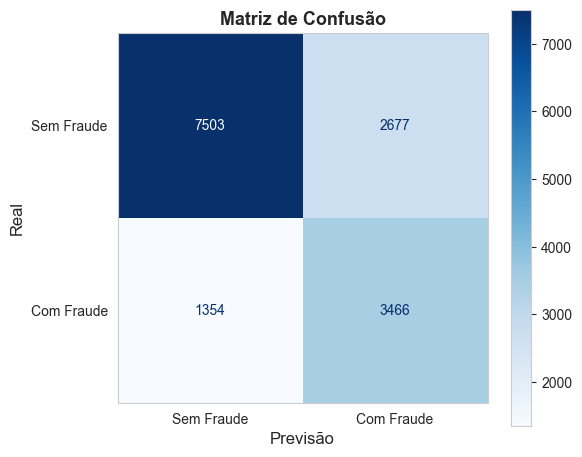

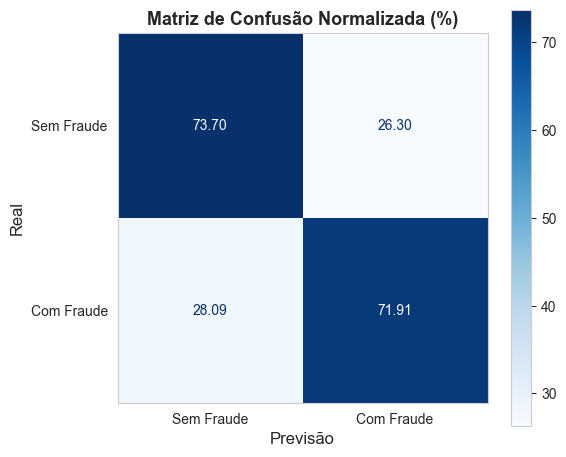

In [ ]:
# Avaliação
y_pred_rl  = rl_best.predict(X_test)
y_proba_rl = rl_best.predict_proba(X_test)[:,1]
imprimeMetricas(y_test, y_pred_rl, y_proba_rl)
imprimeMatrizConfusao(y_test, y_pred_rl)
imprimeMatrizConfusao(y_test, y_pred_rl, norm='true')

# Modelo 2 - KNN


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Melhores params (KNN): {'weights': 'distance', 'p': 1, 'n_neighbors': 13, 'leaf_size': 45}
AUC-ROC: 0.6894

F1 Score: 0.5295

Classification Report:
               precision    recall  f1-score   support

           0     0.7823    0.6987    0.7381     10180
           1     0.4808    0.5892    0.5295      4820

    accuracy                         0.6635     15000
   macro avg     0.6315    0.6440    0.6338     15000
weighted avg     0.6854    0.6635    0.6711     15000



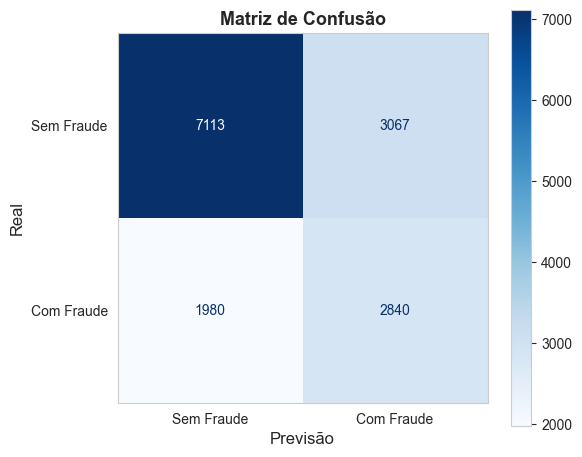

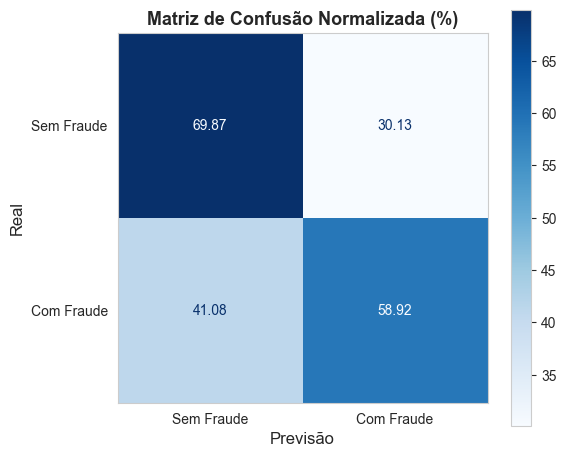

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_dist_knn = {
    "n_neighbors": list(range(3, 61, 2)),   # ímpares geralmente funcionam bem
    "weights": ["uniform", "distance"],
    "p": [1, 2],                             # 1=Manhattan, 2=Euclidiana
    "leaf_size": [15, 30, 45, 60]
}

search_knn = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist_knn,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

search_knn.fit(X_train, y_train)
knn_best = search_knn.best_estimator_
print("Melhores params (KNN):", search_knn.best_params_)

# Avaliação
y_pred  = knn_best.predict(X_test)
y_proba = knn_best.predict_proba(X_test)[:,1]
imprimeMetricas(y_test, y_pred, y_proba)
imprimeMatrizConfusao(y_test, y_pred)
imprimeMatrizConfusao(y_test, y_pred, norm='true')

AUC-ROC: 0.6894

F1 Score: 0.5295

Classification Report:
               precision    recall  f1-score   support

           0     0.7823    0.6987    0.7381     10180
           1     0.4808    0.5892    0.5295      4820

    accuracy                         0.6635     15000
   macro avg     0.6315    0.6440    0.6338     15000
weighted avg     0.6854    0.6635    0.6711     15000



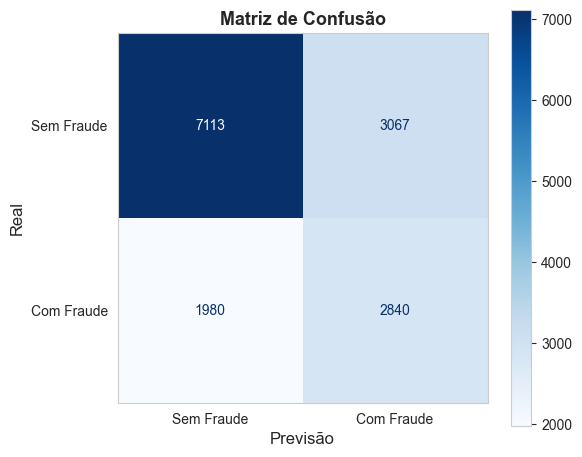

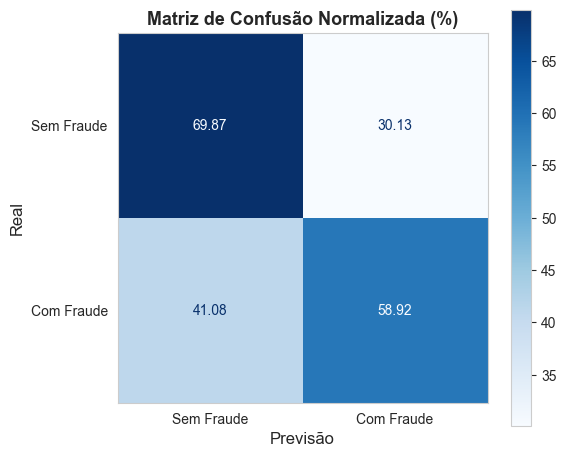

In [ ]:
# Avaliação
y_pred_knn  = knn_best.predict(X_test)
y_proba_knn = knn_best.predict_proba(X_test)[:,1]
imprimeMetricas(y_test, y_pred_knn, y_proba_knn)
imprimeMatrizConfusao(y_test, y_pred_knn)
imprimeMatrizConfusao(y_test, y_pred_knn, norm='true')

# Modelo 3 - XGBoost

In [ ]:
from xgboost import XGBClassifier


# Como já foi aplicado SMOTE no treino, não precisamos de scale_pos_weight aqui
xgb = XGBClassifier(
    objective="binary:logistic", #Problema binário (fraude vs. não fraude). Retorna probabilidade via predict_proba.
    eval_metric="aucpr",            #Em fraude (desbalanceado), AUC-ROC é estável e independe de threshold. Garante que a busca otimize separabilidade entre classes. Mas aucpr foca em positivos raros melhor que auc-roc
    tree_method="hist",             #constrói árvores usando histogramas → acelera o treino e consome menos memória.
    random_state=SEED,
    n_jobs=-1
)

param_dist_xgb = {
    "n_estimators": [300, 500, 800, 1000],  #numero de arvores no ensemble. mais aprendizado, mas pode overfitar.
    "max_depth": [5, 7, 9],             #profundidade máxima das árvores. Controla complexidade (maior profundidade → mais padrões, mas maior risco de overfitting).
    "learning_rate": [0.01, 0.02, 0.05, 0.1], #taxa de aprendizado do gradiente. Quanto menor, mais lento e estável o treino (precisa de mais árvores).
    "subsample": [0.6, 0.8, 1.0],           #fração de amostras usada em cada árvore (bagging). <1.0 adiciona aleatoriedade → reduz overfitting.
    "colsample_bytree": [0.6, 0.8, 1.0],    #fração de features usadas por árvore (feature bagging). Reduz correlação entre árvores.
    "min_child_weight": [0, 1, 3],      #peso mínimo necessário em um nó folha. Valores maiores = modelo mais conservador, evita divisões fracas.
    "gamma": [0, 1]                     #ganho mínimo exigido para dividir um nó. 0 = divide sempre que possível; >0 = mais regularização.
}

search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=40,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    random_state=SEED,
    verbose=0
)

search_xgb.fit(X_train, y_train)
xgb_best = search_xgb.best_estimator_
print("Melhores params (XGB):", search_xgb.best_params_)



Melhores params (XGB): {'subsample': 0.6, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


AUC-ROC: 0.8133

F1 Score: 0.7594

Classification Report:
               precision    recall  f1-score   support

           0     0.8467    0.9940    0.9145     10180
           1     0.9800    0.6199    0.7594      4820

    accuracy                         0.8738     15000
   macro avg     0.9134    0.8070    0.8369     15000
weighted avg     0.8895    0.8738    0.8646     15000



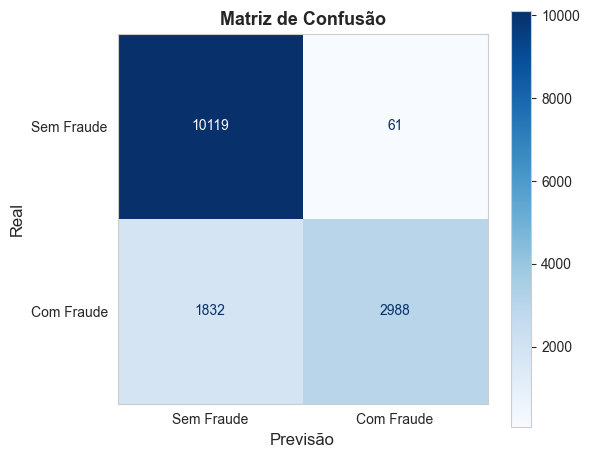

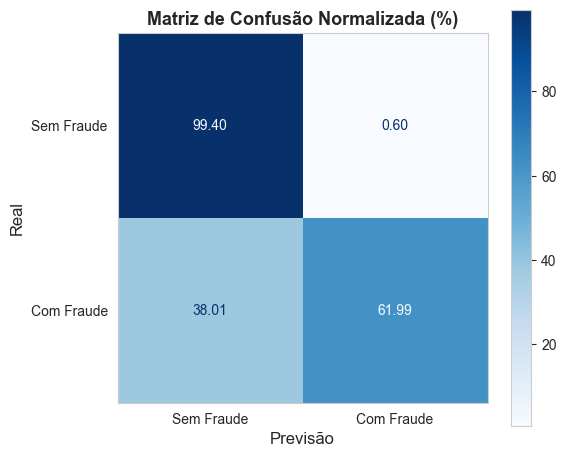

In [ ]:
# Avaliação
y_pred_xgb  = xgb_best.predict(X_test)
y_proba_xgb = xgb_best.predict_proba(X_test)[:,1]
imprimeMetricas(y_test, y_pred_xgb, y_proba_xgb)
imprimeMatrizConfusao(y_test, y_pred_xgb)
imprimeMatrizConfusao(y_test, y_pred_xgb, norm='true')

o RECALL mede a proporção das fraudes reais que o modelo conseguiu pegar.

Interpretação em fraude:

Recall alto → poucas fraudes passam batido.

Recall baixo → muitas fraudes passam e o banco perde dinheiro.

o PRECISION mede a proporção das transações marcadas como fraude que de fato eram fraude.

Interpretação em fraude:

Precision alto → quase todas as operações travadas eram realmente fraude.

Precision baixo → o modelo trava muita operação legítima → irrita clientes e gera custo.

O trade-off:

Se você baixa o threshold, o modelo marca mais operações como fraude → recall sobe, mas precision cai (pega quase tudo, mas enche de falso alarme).

Se você aumenta o threshold, o modelo fica conservador → precision sobe, mas recall cai (só trava quando tem certeza, mas deixa passar mais fraudes).

AUC-ROC: 0.8133

F1 Score: 0.6314

Classification Report:
               precision    recall  f1-score   support

           0     0.8486    0.7292    0.7844     10180
           1     0.5591    0.7253    0.6314      4820

    accuracy                         0.7279     15000
   macro avg     0.7039    0.7272    0.7079     15000
weighted avg     0.7556    0.7279    0.7352     15000



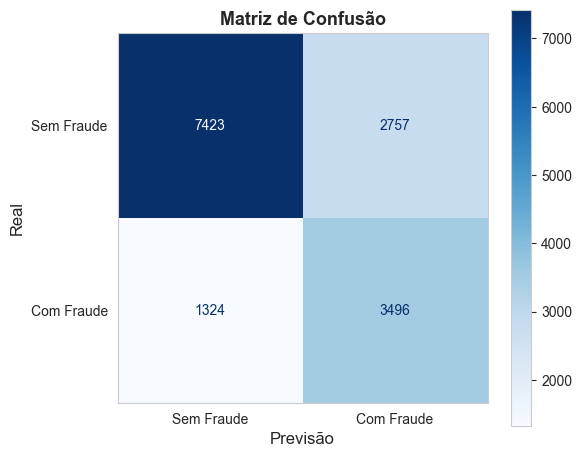

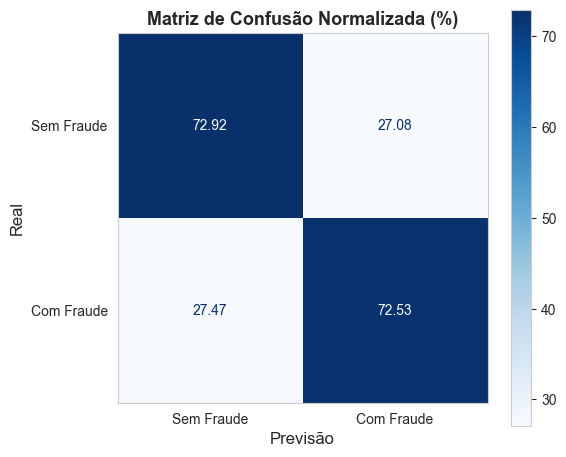

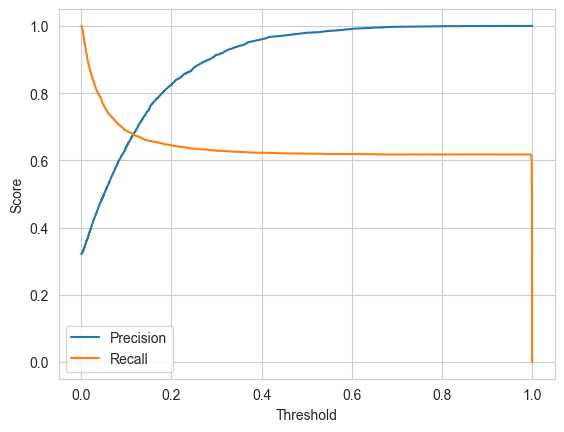

In [ ]:
# Probabilidades previstas (classe 1 = fraude)
y_proba_xgb2 = xgb_best.predict_proba(X_test)[:, 1]

# Definindo threshold manual (sendo o padrao do sklearn 0.5)

#Aqui podemos escolher o threshold, e ir testando.
threshold = 0.07
y_pred_xgb2 = (y_proba_xgb2 >= threshold).astype(int)

# Avaliação
imprimeMetricas(y_test, y_pred_xgb2, y_proba_xgb2)
imprimeMatrizConfusao(y_test, y_pred_xgb2)
imprimeMatrizConfusao(y_test, y_pred_xgb2, norm='true')


# Aqui plotamos a curva precision x recall, para tentar achar o threshold
# mais adequado de acordo com a politica de risco
prec, rec, thr = precision_recall_curve(y_test, y_proba_xgb2)

plt.plot(thr, prec[:-1], label="Precision")
plt.plot(thr, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()


### Porque utilizar o RandomSearchCV?

Porque possui hiperparâmetros contínuos ou grandes faixas.
Ao contrário do GridSearch, por exemplo, que exige testar todas as combinações, o RandomSearchCV, em modelos como Regressão Logística ou o XGBoost, permite amostrar valores dessas faixas, cobrindo regiões muito maiores sem precisar testar tudo.
Para um dataset desse tamanho, é o melhor custo-benefício em tempo de execução. É mais rápido quando limita-se o n_iter.

In [ ]:
# pip install scikit-optimize xgboost
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

# SEED = 42
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# xgb = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="aucpr",
#     tree_method="hist",
#     random_state=SEED,
#     n_jobs=-1
# )

search_spaces = {
    "n_estimators": Integer(300, 1500),
    "max_depth": Integer(3, 10),
    "learning_rate": Real(1e-3, 0.3, prior="log-uniform"),
    "subsample": Real(0.5, 1.0),
    "colsample_bytree": Real(0.5, 1.0),
    "min_child_weight": Integer(1, 10),
    "gamma": Real(0.0, 5.0),            # min_split_loss
}

opt = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces,
    n_iter=40,                    # tipicamente precisa de menos iterações que RandomizedSearch
    scoring="average_precision",  # AUC-PR no sklearn
    cv=cv,
    n_jobs=-1,
    random_state=SEED,
    refit=True,
    return_train_score=False
)

opt.fit(X_train, y_train)
xgb_best2 = opt.best_estimator_
print("Melhores params (Bayes):", opt.best_params_)


Melhores params (Bayes): OrderedDict({'colsample_bytree': 0.8839184323391227, 'gamma': 0.0, 'learning_rate': 0.0604545086993434, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1500, 'subsample': 0.7283480690363596})


AUC-ROC: 0.8118

F1 Score: 0.7594

Classification Report:
               precision    recall  f1-score   support

           0     0.8467    0.9940    0.9145     10180
           1     0.9800    0.6199    0.7594      4820

    accuracy                         0.8738     15000
   macro avg     0.9134    0.8070    0.8369     15000
weighted avg     0.8895    0.8738    0.8646     15000



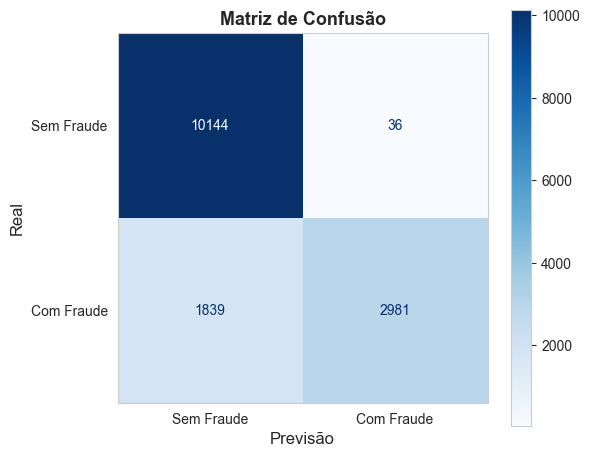

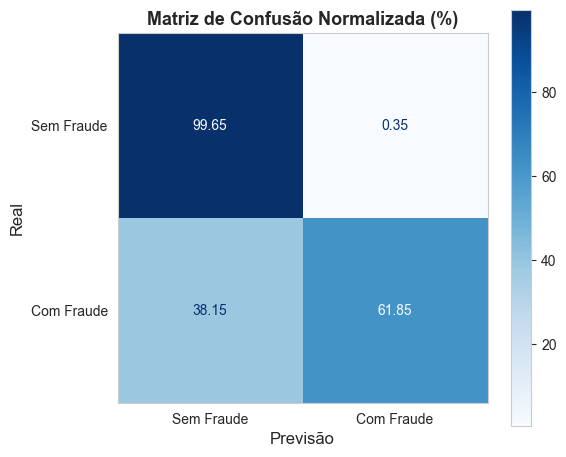

In [ ]:
# Avaliação
y_pred_xgb3  = xgb_best2.predict(X_test)
y_proba_xgb3 = xgb_best2.predict_proba(X_test)[:,1]
imprimeMetricas(y_test, y_pred_xgb, y_proba_xgb3)
imprimeMatrizConfusao(y_test, y_pred_xgb3)
imprimeMatrizConfusao(y_test, y_pred_xgb3, norm='true')

AUC-ROC: 0.8118

F1 Score: 0.6574

Classification Report:
               precision    recall  f1-score   support

           0     0.8461    0.8058    0.8255     10180
           1     0.6273    0.6905    0.6574      4820

    accuracy                         0.7687     15000
   macro avg     0.7367    0.7481    0.7414     15000
weighted avg     0.7758    0.7687    0.7715     15000



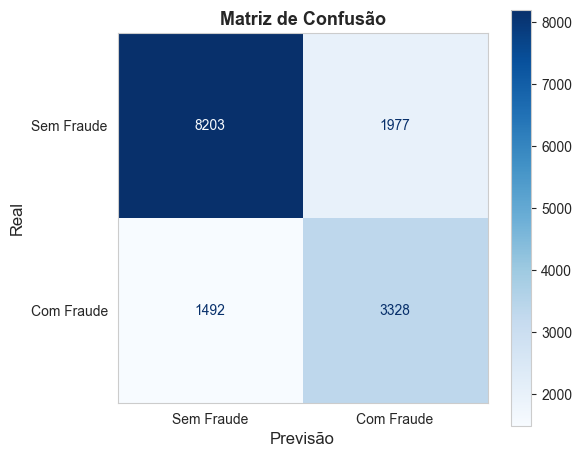

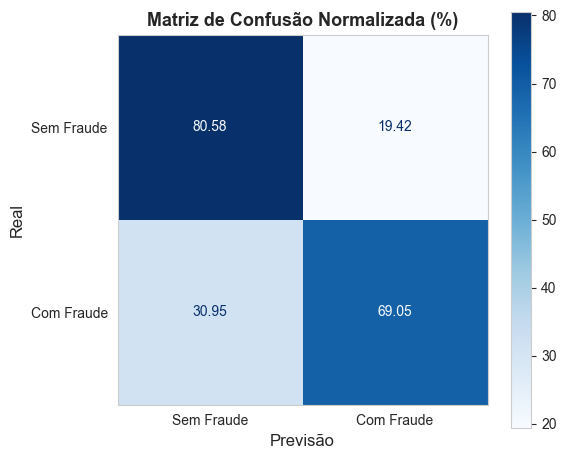

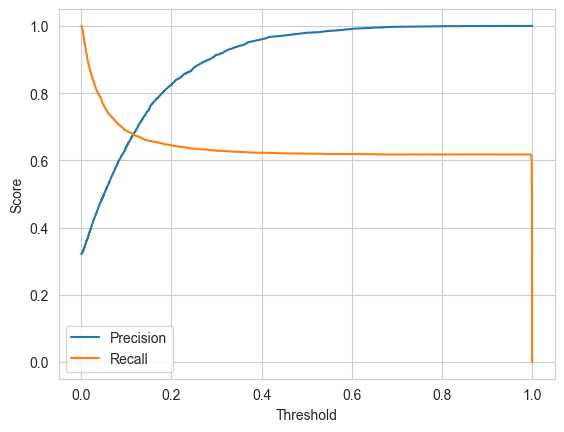

In [ ]:
# Probabilidades previstas (classe 1 = fraude)
y_proba_xgb3 = xgb_best2.predict_proba(X_test)[:, 1]

# Definindo threshold manual (sendo o padrao do sklearn 0.5)

#Aqui podemos escolher o threshold, e ir testando.
threshold = 0.06
y_pred_xgb3 = (y_proba_xgb3 >= threshold).astype(int)

# Avaliação
imprimeMetricas(y_test, y_pred_xgb3, y_proba_xgb3)
imprimeMatrizConfusao(y_test, y_pred_xgb3)
imprimeMatrizConfusao(y_test, y_pred_xgb3, norm='true')


# Aqui plotamos a curva precision x recall, para tentar achar o threshold
# mais adequado de acordo com a politica de risco
prec, rec, thr = precision_recall_curve(y_test, y_proba_xgb2)

plt.plot(thr, prec[:-1], label="Precision")
plt.plot(thr, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

# Qual a *Feature Importance* do Melhor Modelo?

Tabela de Importância das Features:
                            Feature  Importance
6       Failed_Transaction_Count_7d    0.403661
11                          Weekday    0.041613
3      Previous_Fraudulent_Activity    0.033890
2                   IP_Address_Flag    0.029811
4           Daily_Transaction_Count    0.018363
9                        Is_Weekend    0.018287
28    Merchant_Category_Restaurants    0.016056
26    Merchant_Category_Electronics    0.015437
24                   Location_Tokyo    0.015412
22                Location_New York    0.015379
12                            Month    0.015189
20                  Location_London    0.015181
21                  Location_Mumbai    0.015143
37   Authentication_Method_Password    0.014973
23                  Location_Sydney    0.014970
13  Transaction_Type_ATM Withdrawal    0.014955
16             Transaction_Type_POS    0.014941
27      Merchant_Category_Groceries    0.014692
33                   Card_Type_Visa    0.014611
5   

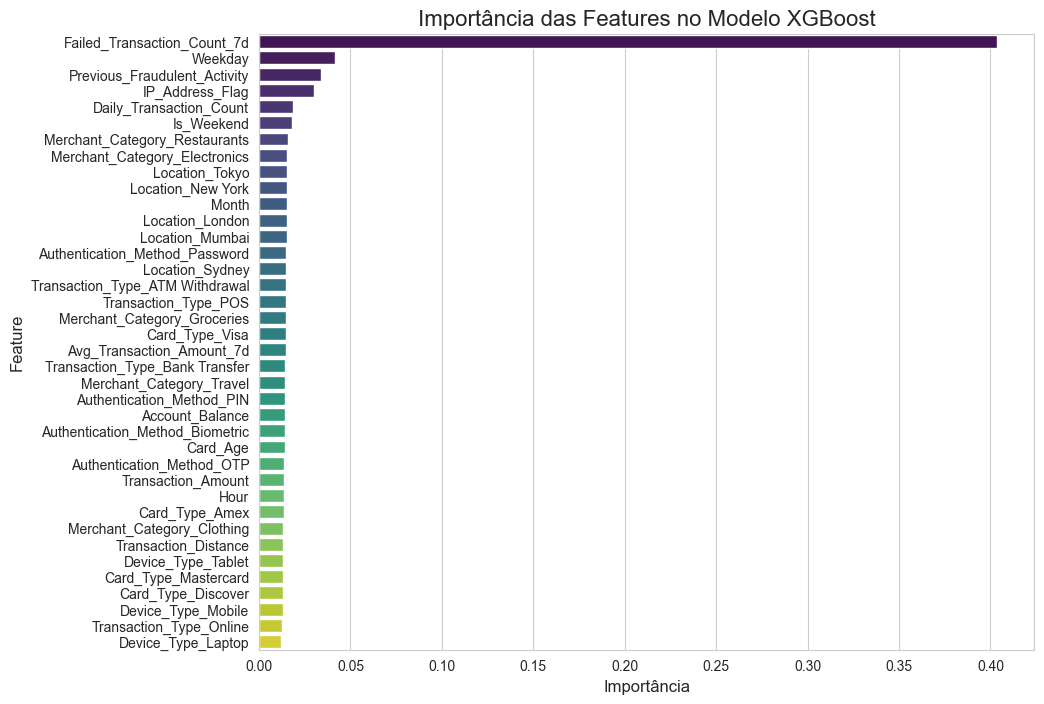

In [ ]:
# Obtendo a importância de cada feature a partir do modelo treinado
feature_importance = xgb_best.feature_importances_

# Criando um DataFrame com as features e suas importâncias
importance_df = pd.DataFrame({'Feature': X_prepro_df.columns, 'Importance': feature_importance})

# Ordenando o DataFrame por importância em ordem decrescente
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Imprimindo a tabela de importância das features
print("Tabela de Importância das Features:")
print(importance_df)

# Plotando um gráfico de barras para visualizar a importância
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Importância das Features no Modelo XGBoost", fontsize=16)
plt.xlabel("Importância", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.show()


A feature de maior relevância, com uma importância de quase 40%, é o Failed_Transaction_Count_7d. Este achado indica que a informação mais crítica para o modelo prever uma fraude é o comportamento recente do usuário em relação a transações falhas. Tal dado sugere uma correlação direta entre tentativas de transação malsucedidas em um curto período e atividades fraudulentas.

Em segundo lugar na hierarquia de importância, e demonstrando o valor da engenharia de features, a variável Weekday se destacou. Embora a análise visual inicial não tenha revelado um padrão óbvio, o modelo foi capaz de identificar uma periodicidade que torna o dia da semana um preditor crucial, superando a maioria das outras variáveis. Este resultado valida a decisão da equipe de criar novas features a partir do Timestamp.

As próximas variáveis de alta relevância, Previous_Fraudulent_Activity e IP_Address_Flag, confirmam a importância de dados históricos e de indicadores técnicos na detecção de fraude. O fato de que transações de usuários com histórico de fraude ou IPs suspeitos são fortemente correlacionadas com um novo evento fraudulento reforça a lógica de sistemas de prevenção.

# Considerações Finais
**1- Meu modelo resolve adequadamente o problema proposto?**

Sim, o modelo resolve o problema ao fornecer uma ferramenta calibrável que permite à empresa adaptar a estratégia de detecção de fraude de acordo com sua tolerância a risco. A análise demonstrou que o modelo XGBoost pode operar em diferentes pontos de equilíbrio:

* Com o limiar padrão, o modelo alcançou 98% de precisão. Esta configuração é ideal se a empresa prioriza a experiência do cliente, minimizando falsos alarmes e reduzindo custos com investigações de transações legítimas.

* Ao ajustar o limiar, demonstramos que é possível aumentar a taxa de detecção de fraudes (Recall) para aproximadamente 69%. Este resultado representa um ganho significativo, significando que o sistema é capaz de identificar e bloquear quase 7 em cada 10 transações fraudulentas que, de outra forma, resultariam em prejuízo direto para a instituição.

Portanto, a adequação do modelo não reside em uma única métrica perfeita, mas na sua flexibilidade para se alinhar a diferentes objetivos de negócio.

**2- Meu modelo pode ser colocado em produção?**

Sim, o modelo é um candidato viável para a produção, pois sua construção foi metodologicamente robusta e seu desempenho é bem compreendido. A remoção do Risk_Score e a aplicação do SMOTE apenas no treino garantem que o modelo não está superajustado ou dependente de vazamentos de dados, e que ele generaliza bem.

No entanto, a sua implantação deve ser acompanhada por um plano que garanta sua longevidade e eficácia, incluindo:

* Superioridade Comprovada: Ele superou os outros modelos de linha de base (Regressão Logística e kNN) em métricas-chave como F1-Score e AUC-ROC.

* Resistência a Erros: A remoção do Risk_Score e a aplicação do SMOTE apenas no treino garantem que o modelo não está superajustado ou dependente de vazamentos de dados, e que ele generaliza bem.

No entanto, a sua implantação deve ser acompanhada por um plano que garanta sua longevidade e eficácia, incluindo:

* Colaboração Estratégica: A decisão final sobre o limiar de decisão deve ser tomada em conjunto com os gestores de negócio, para que o modelo opere de acordo com a tolerância de risco da empresa.

* Monitoramento e Manutenção Contínua: Devido à natureza dinâmica das fraudes, o modelo deve ser monitorado regularmente em produção. A performance e a distribuição de dados devem ser verificadas continuamente para que o modelo possa ser retreinado quando os padrões de fraude mudarem.